In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch import nn, optim
import matplotlib.pyplot as plt
import os

Auto-Encoder模型

In [2]:
class AE(nn.Module):

    def __init__(self):
        # 调用父类方法初始化模块的state
        super(AE, self).__init__()

        # 编码器 ： [b, 784] => [b, 20]
        self.encoder = nn.Sequential(nn.Linear(784, 256), nn.ReLU(),
                                     nn.Linear(256, 20), nn.ReLU())

        # 解码器 ： [b, 20] => [b, 784]
        self.decoder = nn.Sequential(
            nn.Linear(20, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # 图片数值取值为[0,1]，不宜用ReLU
        )

    def forward(self, x):
        """
        向前传播部分, 在model_name(inputs)时自动调用
        :param x: the input of our training model
        :return: the result of our training model
        """
        batch_size = x.shape[0]  # 每一批含有的样本的个数
        # flatten
        # tensor.view()方法可以调整tensor的形状，但必须保证调整前后元素总数一致。view不会修改自身的数据，
        # 返回的新tensor与原tensor共享内存，即更改一个，另一个也随之改变。
        x = x.view(batch_size, 784)  # 一行代表一个样本

        # encoder
        x = self.encoder(x)

        # decoder
        x = self.decoder(x)

        # reshape
        x = x.view(batch_size, 1, 28, 28)
        return x

In [3]:
# 超参数设置
# Hyper-parameters
image_size = 784    # mnist数据集中一张图片的size，28*28
num_epochs = 100 # 迭代次数
batch_size = 128    # 一批样本的数量
learning_rate = 1e-3    # 学习率

In [4]:
plt.style.use("ggplot")

# 下载mnist数据集
mnist_train = datasets.MNIST(root='./data/mnist',
                                train=True,
                                transform=transforms.Compose(
                                    [transforms.ToTensor()]),
                                download=True)
mnist_test = datasets.MNIST(root='./data/mnist',
                            train=False,
                            transform=transforms.Compose(
                                [transforms.ToTensor()]),
                            download=True)

# 载入mnist数据集
# batch_size设置每一批数据的大小，shuffle设置是否打乱数据顺序，结果表明，该函数会先打乱数据再按batch_size取数据
mnist_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)                            

In [5]:
# 查看每一个batch图片的规模
x, label = iter(mnist_train).__next__()  # 取出第一批(batch)训练所用的数据集
print(' img : ', x.shape
        )  # img :  torch.Size([128, 1, 28, 28])， 每次迭代获取128张图片，每张图大小为(1,28,28)


 img :  torch.Size([128, 1, 28, 28])


In [6]:
# 准备工作 : 搭建计算流程
device = torch.device('cuda')
print(device)
AEmodel = AE().to(device)  # 生成AE模型，并转移到GPU上去
print('The structure of our model is shown below: \n')
print(AEmodel)
loss_function = nn.MSELoss()  # 生成损失函数
optimizer = optim.Adam(AEmodel.parameters(),
                        lr=learning_rate)  # 生成优化器，需要优化的是model的参数，学习率为0.001

cuda
The structure of our model is shown below: 

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=20, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [7]:
# 开始迭代
num_epochs=10
loss_epoch = []
for epoch in range(num_epochs):
    # 每一代都要遍历所有的批次
    for batch_index, (x, _) in enumerate(mnist_train):
        # [b, 1, 28, 28]
        x = x.to(device)
        # 前向传播
        x_hat = AEmodel(x)  # 模型的输出，在这里会自动调用model中的forward函数
        loss = loss_function(x_hat, x)  # 计算损失值，即目标函数
        # 后向传播
        optimizer.zero_grad()  # 梯度清零，否则上一步的梯度仍会存在
        loss.backward()  # 后向传播计算梯度，这些梯度会保存在model.parameters里面
        optimizer.step()  # 更新梯度，这一步与上一步主要是根据model.parameters联系起来了

    loss_epoch.append(loss.item())
    if epoch % (num_epochs // 10) == 0:
        print('Epoch [{}/{}] : '.format(epoch, num_epochs), 'loss = ',
                loss.item())  # loss是Tensor类型
torch.save(AEmodel,'AE_mnist.pth')
# x, _ = iter(mnist_test).__next__()   # 在测试集中取出一部分数据
# with torch.no_grad():
#     x_hat = model(x)


Epoch [0/10] :  loss =  0.026693804189562798
Epoch [1/10] :  loss =  0.020975418388843536
Epoch [2/10] :  loss =  0.02221994288265705
Epoch [3/10] :  loss =  0.02049495279788971
Epoch [4/10] :  loss =  0.018461525440216064
Epoch [5/10] :  loss =  0.017441708594560623
Epoch [6/10] :  loss =  0.017157604917883873
Epoch [7/10] :  loss =  0.019108084961771965
Epoch [8/10] :  loss =  0.016986755654215813
Epoch [9/10] :  loss =  0.016092710196971893


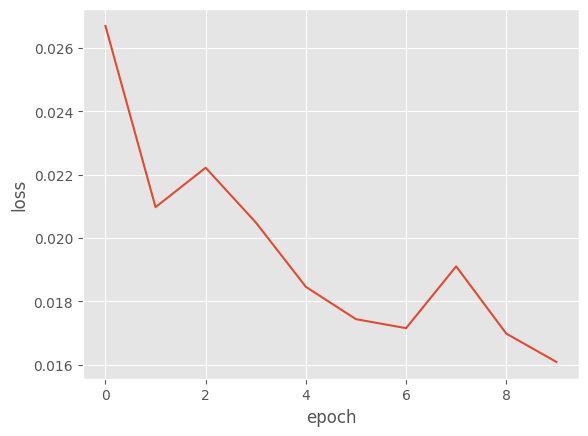

In [8]:
# 绘制训练结果
plt.plot(loss_epoch)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [15]:
ae_mnist=torch.load('AE_mnist.pth')
# 重构的图像
print(x.shape)
out= ae_mnist(x)  # 对最后一个batch的样本进行重构，最后一个batch的样本只有96个，因此x的维度是(96,784)，输出的vector维度也是(96,784)
print(out.shape)

x_concat = torch.cat([x.view(-1, 1, 28, 28),
                        out.view(-1, 1, 28, 28)],
                        dim=3)  # 将原始输入的向量和重构的向量拼接，拼接的是第3维，输出维度是(96,1,28,56)
# print(x_concat.shape)
save_image(x_concat,
            os.path.join('./results/',
                        'ae_reconst-1.png'))  # 保存重构的图片

torch.Size([96, 1, 28, 28])
torch.Size([96, 1, 28, 28])
